In [ ]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

In [ ]:
# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 327s 0us/step


In [ ]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
print(type(annotations), len(annotations), list(annotations.keys()), type(annotations['annotations']))
annotations['annotations'][:2]

<class 'dict'> 4 ['info', 'images', 'licenses', 'annotations'] <class 'list'>


[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100}]

In [ ]:
# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
pickle.dump(train_captions, open('/content/drive/My Drive/Image Captioning/NEW/train_captions.pickle' , 'wb' ))
pickle.dump(img_name_vector, open('/content/drive/My Drive/Image Captioning/NEW/img_name_vector.pickle' , 'wb' ))

In [ ]:
train_captions = None
with open('/content/drive/My Drive/Image Captioning/NEW/train_captions.pickle', 'rb') as handle:
    train_captions = pickle.load(handle)
img_name_vector = None
with open('/content/drive/My Drive/Image Captioning/NEW/img_name_vector.pickle', 'rb') as handle:
    img_name_vector = pickle.load(handle)
print(len(train_captions), len(img_name_vector))

30000 30000


In [ ]:
import xlsxwriter 
workbook = xlsxwriter.Workbook('/content/drive/My Drive/Image Captioning/NEW/English.xlsx') 
worksheet = workbook.add_worksheet() 

for i, each in enumerate(train_captions):
  if len(each) != 0:
    worksheet.write('A' + str(i+1), each[8:-6]) 
  
# Finally, close the Excel file 
# via the close() method. 
workbook.close() 

In [ ]:
train_captions_persian_demo = open("/content/drive/My Drive/Image Captioning/NEW/Persian_captions.txt", "r").read().split('\n')
train_captions_persian_demo.remove('')
train_captions_persian = []
for each in train_captions_persian_demo:
  if len(each) != 0:    
    train_captions_persian.append('<شروع> ' + each + ' <پایان>')
print(len(train_captions_persian))

30000


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
counter = 0
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  print(counter)
  counter += 1

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
english_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

persian_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
english_tokenizer.fit_on_texts(train_captions)
persian_tokenizer.fit_on_texts(train_captions_persian)
train_seqs = english_tokenizer.texts_to_sequences(train_captions)
train_seqs_persian = persian_tokenizer.texts_to_sequences(train_captions_persian)

In [ ]:
english_tokenizer.word_index['<pad>'] = 0
english_tokenizer.index_word[0] = '<pad>'
persian_tokenizer.word_index['<pad>'] = 0
persian_tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = english_tokenizer.texts_to_sequences(train_captions)
train_seqs_persian = persian_tokenizer.texts_to_sequences(train_captions_persian)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector_persian = tf.keras.preprocessing.sequence.pad_sequences(train_seqs_persian, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs + train_seqs_persian)

In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val, cap_persian_train, cap_persian_val = train_test_split(img_name_vector, cap_vector, cap_vector_persian, test_size=0.2, random_state=0)

In [ ]:
len(img_name_train), len(img_name_val), len(cap_train), len(cap_val), len(cap_persian_train), len(cap_persian_val)

(24000, 6000, 24000, 6000, 24000, 6000)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
vocab_size_p = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64



---




Multi-Task Learning

In [ ]:
# Load the numpy files
def map_func(img_name, cap, cap_persian):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap, cap_persian

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train, cap_persian_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, vocab_size_p):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.embedding_p = tf.keras.layers.Embedding(vocab_size_p, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru_p = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc1_p = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.fc2_p = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, x_p, features, hidden, hidden_p):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    context_vector_p, attention_weights_p = self.attention(features, hidden_p)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    x_p = self.embedding_p(x_p)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    x_p = tf.concat([tf.expand_dims(context_vector_p, 1), x_p], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    output_p, state_p = self.gru_p(x_p)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    x_p = self.fc1_p(output_p)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    x_p = tf.reshape(x_p, (-1, x_p.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    x_p = self.fc2_p(x_p)

    return x, state, x_p, state_p, attention_weights, attention_weights_p

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size, vocab_size_p)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/drive/My Drive/Image Captioning/Another :)/train-multi"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target, target_persian):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden_p = decoder.reset_state(batch_size=target_persian.shape[0])

  dec_input = tf.expand_dims([english_tokenizer.word_index['<start>']] * target.shape[0], 1)
  dec_input_persian = tf.expand_dims([persian_tokenizer.word_index['<شروع>']] * target_persian.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, min(target.shape[1], target_persian.shape[1])):
          # passing the features through the decoder
          predictions, hidden, predictions_persian, hidden_p, _, _ = decoder(dec_input, dec_input_persian, features, hidden, hidden_p)
          
          loss += loss_function(target[:, i], predictions) + loss_function(target_persian[:, i], predictions_persian)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          dec_input_persian = tf.expand_dims(target_persian[:, i], 1)

  total_loss = (loss / int(target.shape[1]) + int(target_persian.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    # for each in enumerate(dataset):
    #   print(len(each))
    #   break
    for (batch, (img_tensor, target, target_persian)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target, target_persian)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Persian Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]), batch_loss.numpy() / int(target_persian.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.2672 Persian Loss 3.0303
Epoch 1 Batch 100 Loss 2.3699 Persian Loss 1.6830
Epoch 1 Batch 200 Loss 2.1630 Persian Loss 1.5361
Epoch 1 Batch 300 Loss 2.1000 Persian Loss 1.4913
Epoch 1 Loss 71.174637
Time taken for 1 epoch 447.06336426734924 sec

Epoch 2 Batch 0 Loss 1.6998 Persian Loss 1.2071
Epoch 2 Batch 100 Loss 1.7054 Persian Loss 1.2111
Epoch 2 Batch 200 Loss 1.8463 Persian Loss 1.3112
Epoch 2 Batch 300 Loss 1.5724 Persian Loss 1.1167
Epoch 2 Loss 70.667519
Time taken for 1 epoch 386.19542264938354 sec

Epoch 3 Batch 0 Loss 1.5504 Persian Loss 1.1010
Epoch 3 Batch 100 Loss 1.4885 Persian Loss 1.0571
Epoch 3 Batch 200 Loss 1.4780 Persian Loss 1.0496
Epoch 3 Batch 300 Loss 1.4060 Persian Loss 0.9985
Epoch 3 Loss 70.525856
Time taken for 1 epoch 383.39630103111267 sec

Epoch 4 Batch 0 Loss 1.3513 Persian Loss 0.9596
Epoch 4 Batch 100 Loss 1.3614 Persian Loss 0.9668
Epoch 4 Batch 200 Loss 1.4230 Persian Loss 1.0105
Epoch 4 Batch 300 Loss 1.3385 Persian Loss 0.950

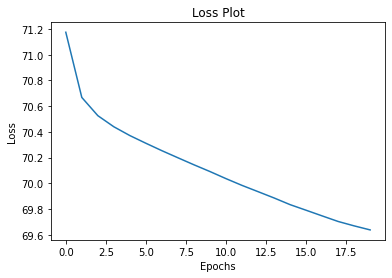

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    hidden_p = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([english_tokenizer.word_index['<start>']], 0)
    dec_input_p = tf.expand_dims([persian_tokenizer.word_index['<شروع>']], 0)
    result = []
    result_p = []

    for i in range(max_length):
        
        predictions, hidden, predictions_persian, hidden_p, attention_weights, attention_weights_p = decoder(dec_input, dec_input_p, features, hidden, hidden_p)

        attention_plot[i] = tf.reshape(attention_weights_p, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_id_p = tf.random.categorical(predictions_persian, 1)[0][0].numpy()
        result.append(english_tokenizer.index_word[predicted_id])
        result_p.append(persian_tokenizer.index_word[predicted_id_p])

        # if english_tokenizer.index_word[predicted_id] == '<end>' or persian_tokenizer.index_word[predicted_id] == '<پایان>':
        if persian_tokenizer.index_word[predicted_id_p] == '<پایان>':
            # print(result)
            # print(result_p)
            return result_p, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
        dec_input_p = tf.expand_dims([predicted_id_p], 0)

    attention_plot = attention_plot[:len(result), :]
    return result_p, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
real_captions = []
for rid in range(0, len(cap_persian_val)):
  real_captions.append(' '.join([persian_tokenizer.index_word[i] for i in cap_persian_val[rid] if i not in [0]])[7:-8].split())
print(len(real_captions))

6000


In [ ]:
predicted_captions = []
for i, image in enumerate(img_name_val):
  result, attention_plot = evaluate(image)
  result = ' '.join(result)[:-8]
  predicted_captions.append(result.split())
  print(i)
print(len(predicted_captions))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
print(' BLEU-1: %f' % corpus_bleu(real_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
print(' BLEU-2: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))
print(' BLEU-3: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.3, 0.3, 0.3, 0)))
print(' BLEU-4: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 BLEU-1: 0.020996
 BLEU-2: 0.144901
 BLEU-3: 0.313793
 BLEU-4: 0.380659


['a', 'giraffe', 'that', 'is', 'grazing', 'inside', '<end>']
['زرافه', 'در', 'نزدیکی', 'حصار', 'به', 'دنبال', 'غذا']
Real Caption: <start> a giraffe is standing by a fence in the grass <end>
Prediction Caption: a giraffe that is grazing inside <end>


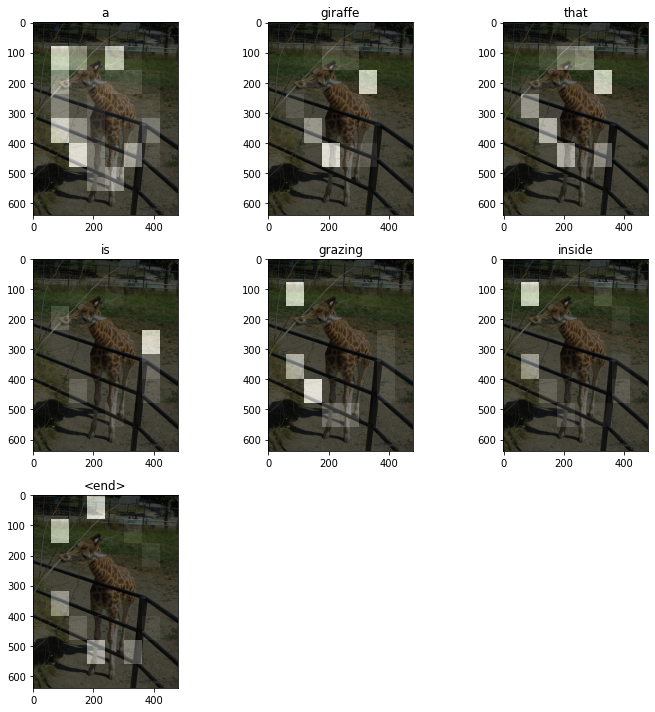

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([english_tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

['a', 'surfer', 'rides', 'a', 'surfboard', 'in', 'the', 'overhead', '<end>']
['یک', 'مرد', 'در', 'هنگام', 'سوار', 'تخته', 'موج', 'کت', 'و']
Prediction Caption: a surfer rides a surfboard in the overhead <end>


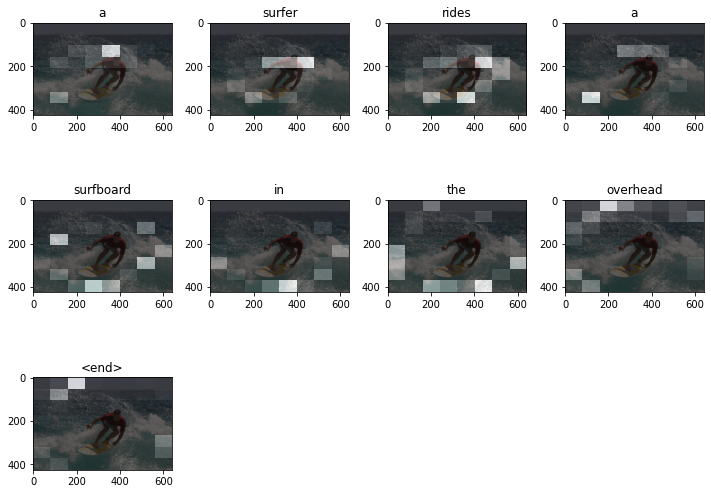

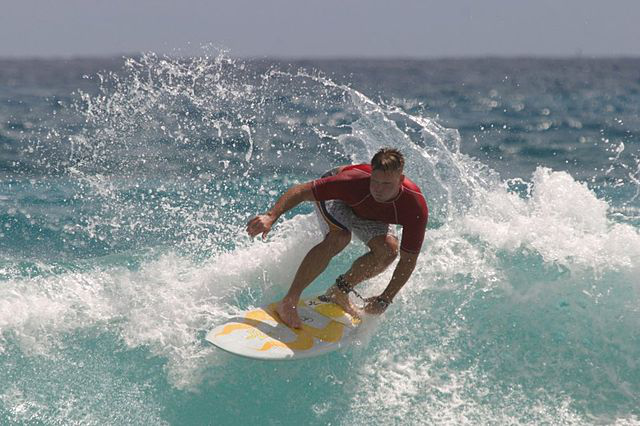

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)



---



Single-Task Learning

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_persian_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size_p)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/content/drive/My Drive/Image Captioning/Another :)/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([persian_tokenizer.word_index['<شروع>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.5572
Epoch 1 Batch 100 Loss 0.9188
Epoch 1 Batch 200 Loss 0.7254
Epoch 1 Batch 300 Loss 0.7243
Epoch 1 Loss 0.833414
Time taken for 1 epoch 413.13198590278625 sec

Epoch 2 Batch 0 Loss 0.6760
Epoch 2 Batch 100 Loss 0.6657
Epoch 2 Batch 200 Loss 0.6554
Epoch 2 Batch 300 Loss 0.6095
Epoch 2 Loss 0.636383
Time taken for 1 epoch 377.41537046432495 sec

Epoch 3 Batch 0 Loss 0.5960
Epoch 3 Batch 100 Loss 0.5857
Epoch 3 Batch 200 Loss 0.5983
Epoch 3 Batch 300 Loss 0.5849
Epoch 3 Loss 0.581650
Time taken for 1 epoch 376.63158917427063 sec

Epoch 4 Batch 0 Loss 0.5416
Epoch 4 Batch 100 Loss 0.4980
Epoch 4 Batch 200 Loss 0.5423
Epoch 4 Batch 300 Loss 0.5633
Epoch 4 Loss 0.548022
Time taken for 1 epoch 375.84029507637024 sec

Epoch 5 Batch 0 Loss 0.5053
Epoch 5 Batch 100 Loss 0.6348
Epoch 5 Batch 200 Loss 0.5354
Epoch 5 Batch 300 Loss 0.5263
Epoch 5 Loss 0.521978
Time taken for 1 epoch 376.184054851532 sec

Epoch 6 Batch 0 Loss 0.5008
Epoch 6 Batch 100 Loss 0.5399
Epoch 6 B

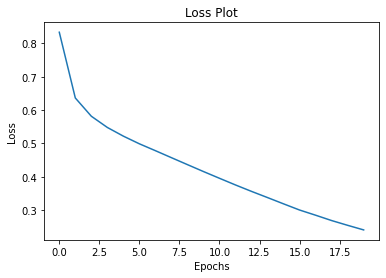

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([persian_tokenizer.word_index['<شروع>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(persian_tokenizer.index_word[predicted_id])

        if persian_tokenizer.index_word[predicted_id] == '<پایان>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
real_captions = []
for rid in range(0, len(cap_persian_val)):
  real_captions.append(' '.join([persian_tokenizer.index_word[i] for i in cap_persian_val[rid] if i not in [0]])[7:-8].split())
print(len(real_captions))

6000


In [ ]:
predicted_captions = []
for i, image in enumerate(img_name_val):
  result, attention_plot = evaluate(image)
  result = ' '.join(result)[:-8]
  predicted_captions.append(result.split())
  print(i)
print(len(predicted_captions))

In [ ]:
print(' BLEU-1: %f' % corpus_bleu(real_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
print(' BLEU-2: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))
print(' BLEU-3: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.3, 0.3, 0.3, 0)))
print(' BLEU-4: %f' % corpus_bleu(real_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 BLEU-1: 0.021583
 BLEU-2: 0.146911
 BLEU-3: 0.316397
 BLEU-4: 0.383290


Real Caption: <شروع> مردی که در یک اسکیت بورد در حال ریزش در راه آهن است <پایان>
Prediction Caption: اسکیت باز در هوا بر روی تپه قرار می کند <پایان>


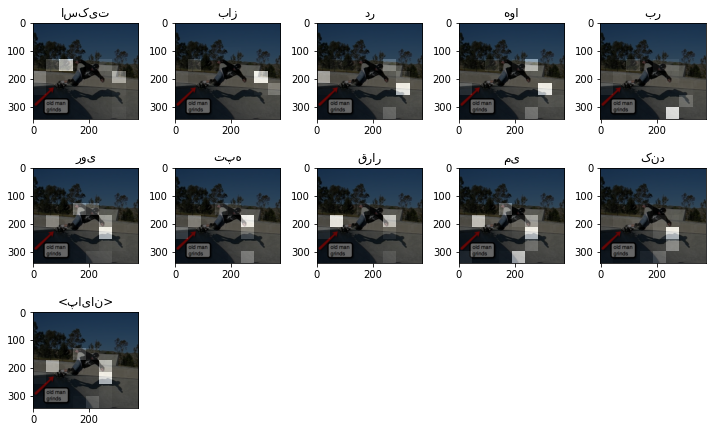

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([persian_tokenizer.index_word[i] for i in cap_persian_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: مردی با لباس اسکی روی موج سوار می شود <پایان>


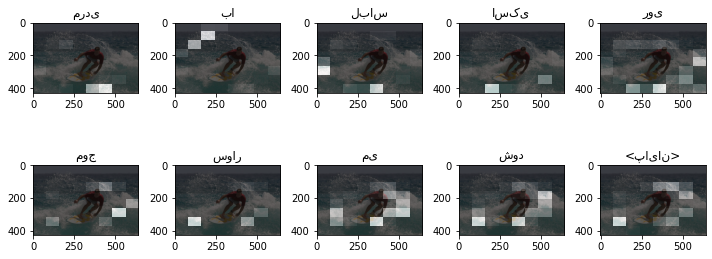

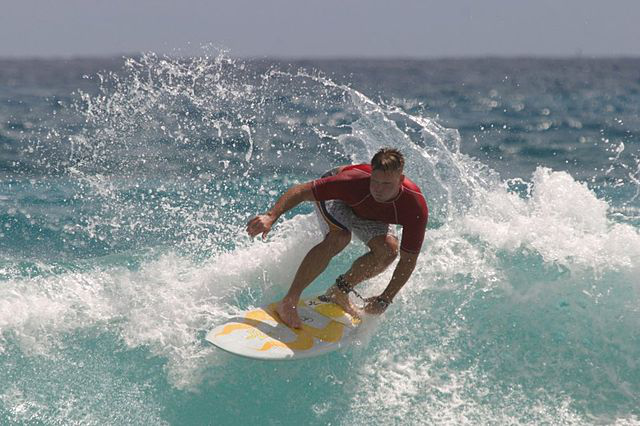

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)



---


